Copyright (c) Microsoft Corporation. All rights reserved.  
Licensed under the MIT License.

# 02. Facial Expression Recognition using ONNX Runtime GPU on AzureML

This example shows how to deploy an image classification neural network using the Facial Expression Recognition ([FER](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data)) dataset and Open Neural Network eXchange format ([ONNX](http://aka.ms/onnxdocarticle)) on the Azure Machine Learning platform. This tutorial will show you how to deploy a FER+ model from the [ONNX model zoo](https://github.com/onnx/models), use it to make predictions using ONNX Runtime Inference, and deploy it as a web service in Azure.

Throughout this tutorial, we will be referring to ONNX, a neural network exchange format used to represent deep learning models. With ONNX, AI developers can more easily move models between state-of-the-art tools (CNTK, PyTorch, Caffe, MXNet, TensorFlow) and choose the combination that is best for them. ONNX is developed and supported by a community of partners including Microsoft AI, Facebook, and Amazon. For more information, explore the [ONNX website](http://onnx.ai) and [open source files](https://github.com/onnx).

[ONNX Runtime](https://aka.ms/onnxruntime) is the runtime engine that enables evaluation of trained machine learning (Traditional ML and Deep Learning) models with high performance and low resource utilization.

#### Tutorial Objectives:

1. Describe the FER+ dataset and pretrained Convolutional Neural Net ONNX model for Emotion Recognition, stored in the ONNX model zoo.
2. Deploy and run the pretrained FER+ ONNX model on an Azure Machine Learning instance
3. Predict labels for test set data points in the cloud using ONNX Runtime and Azure ML

## Prerequisites

### 1. Install Azure ML SDK and create a new workspace
Please follow [00.configuration.ipynb](https://github.com/Azure/MachineLearningNotebooks/blob/master/00.configuration.ipynb) notebook.


### 2. Install additional packages needed for this Notebook
You need to install the popular plotting library `matplotlib` and the `onnx` library in the conda environment where Azure Maching Learning SDK is installed.

```sh
(myenv) $ pip install matplotlib onnx
```

### 3. Download sample data and pre-trained ONNX model from ONNX Model Zoo.

[Download the ONNX Emotion FER+ model and corresponding test data](https://www.cntk.ai/OnnxModels/emotion_ferplus/opset_7/emotion_ferplus.tar.gz) and place them in the same folder as this tutorial notebook. You can unzip the file through the following line of code.

```sh
(myenv) $ tar xvzf emotion_ferplus.tar.gz
```

More information can be found about the ONNX FER+ model on [github](https://github.com/onnx/models/tree/master/emotion_ferplus). For more information about the FER+ dataset, please visit Microsoft Researcher Emad Barsoum's [FER+ source data repository](https://github.com/ebarsoum/FERPlus).

## Load Azure ML workspace

We begin by instantiating a workspace object from the existing workspace created earlier in the configuration notebook.

In [ ]:
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)

In [ ]:
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.location, sep = '\n')

### Registering your model with Azure ML

In [ ]:
model_dir = "emotion_ferplus" # replace this with the location of your model files

# leave as is if it's in the same folder as this notebook

In [ ]:
from azureml.core.model import Model

model = Model.register(model_path = model_dir + "/" + "model.onnx",
                       model_name = "onnx_emotion",
                       tags = {"onnx": "demo"},
                       description = "FER+ emotion recognition CNN from ONNX Model Zoo",
                       workspace = ws)

### Optional: Displaying your registered models

This step is not required, so feel free to skip it.

In [ ]:
models = ws.models()
for m in models:
    print("Name:", m.name,"\tVersion:", m.version, "\tDescription:", m.description, m.tags)

### ONNX FER+ Model Methodology

The image classification model we are using is pre-trained using Microsoft's deep learning cognitive toolkit, [CNTK](https://github.com/Microsoft/CNTK), from the [ONNX model zoo](http://github.com/onnx/models). The model zoo has many other models that can be deployed on cloud providers like AzureML without any additional training. To ensure that our cloud deployed model works, we use testing data from the famous FER+ data set, provided as part of the [trained Emotion Recognition model](https://github.com/onnx/models/tree/master/emotion_ferplus) in the ONNX model zoo.

The original Facial Emotion Recognition (FER) Dataset was released in 2013, but some of the labels are not entirely appropriate for the expression. In the FER+ Dataset, each photo was evaluated by at least 10 croud sourced reviewers, creating a better basis for ground truth. 

You can see the difference of label quality in the sample model input below. The FER labels are the first word below each image, and the FER+ labels are the second word below each image.

![](https://raw.githubusercontent.com/Microsoft/FERPlus/master/FER+vsFER.png)

***Input: Photos of cropped faces from FER+ Dataset***

***Task: Classify each facial image into its appropriate emotions in the emotion table***

```    emotion_table = {'neutral':0, 'happiness':1, 'surprise':2, 'sadness':3, 'anger':4, 'disgust':5, 'fear':6, 'contempt':7} ```

***Output: Emotion prediction for input image***


Remember, once the application is deployed in Azure ML, you can use your own images as input for the model to classify.

In [ ]:
# for images and plots in this notebook
import matplotlib.pyplot as plt  
from IPython.display import Image

# display images inline
%matplotlib inline

### Model Description

The FER+ model from the ONNX Model Zoo is summarized by the graphic below. You can see the entire workflow of our pre-trained model in the following image from Barsoum et. al's paper ["Training Deep Networks for Facial Expression Recognition
with Crowd-Sourced Label Distribution"](https://arxiv.org/pdf/1608.01041.pdf), with our (64,64) input images and our output probabilities for each of the labels.

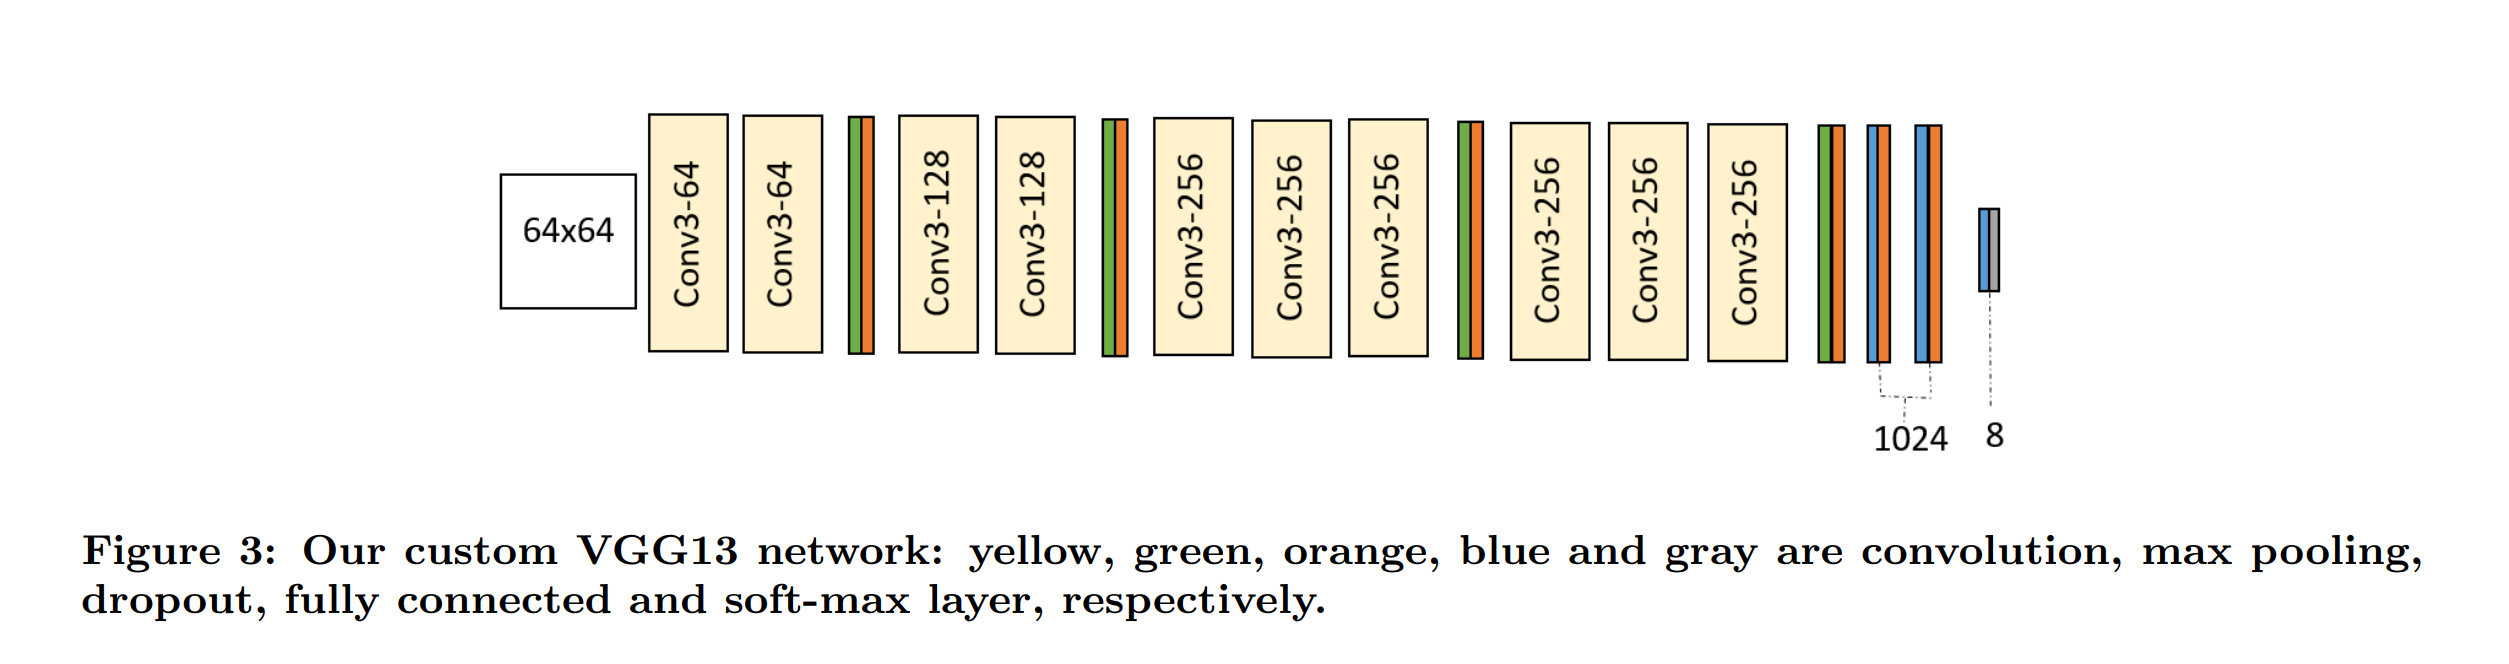

## Deploy our model on Azure ML

We are now going to deploy our ONNX Model on AML with inference in ONNX Runtime. We begin by writing a score.py file, which will help us run the model in our Azure ML virtual machine (VM), and then specify our environment by writing a yml file.

You will also notice that we import the onnxruntime library to do runtime inference on our ONNX models (passing in input and evaluating out model's predicted output). More information on the API and commands can be found in the [ONNX Runtime documentation](https://aka.ms/onnxruntime).

### Write Score File

A score file is what tells our Azure cloud service what to do. After initializing our model using azureml.core.model, we start an ONNX Runtime GPU inference session to evaluate the data passed in on our function calls.

In [ ]:
%%writefile score.py
import json
import numpy as np
import onnxruntime
import sys
import os
from azureml.core.model import Model
import time

def init():
    global session
    model = Model.get_model_path(model_name = 'onnx_emotion')
    session = onnxruntime.InferenceSession(model, None)
    
def run(input_data):
    '''Purpose: evaluate test input in Azure Cloud using onnxruntime.
        We will call the run function later from our Jupyter Notebook 
        so our azure service can evaluate our model input in the cloud. '''

    try:
        # load in our data, convert to readable format
        start = time.time()
        data = np.array(json.loads(input_data)['data']).astype('float32')

        r = session.run(["Plus214_Output_0"], {"Input3": data})[0]
        result = emotion_map(postprocess(r[0]))
        end = time.time()
        result_dict = {"result": np.array(result).tolist(),
                      "time": np.array(end - start).tolist()}
    except Exception as e:
        result_dict = {"error": str(e)}
    
    return json.dumps(result_dict)

def emotion_map(classes, N=1):
    """Take the most probable labels (output of postprocess) and returns the top N emotional labels that fit the picture."""
    
    emotion_table = {'neutral':0, 'happiness':1, 'surprise':2, 'sadness':3, 'anger':4, 'disgust':5, 'fear':6, 'contempt':7}
    emotion_keys = list(emotion_table.keys())
    emotions = []
    for i in range(N):
        emotions.append(emotion_keys[classes[i]])
    return emotions

def softmax(x):
    """Compute softmax values (probabilities from 0 to 1) for each possible label."""
    x = x.reshape(-1)
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def postprocess(scores):
    """This function takes the scores generated by the network and returns the class IDs in decreasing 
    order of probability."""
    prob = softmax(scores)
    prob = np.squeeze(prob)
    classes = np.argsort(prob)[::-1]
    return classes

### Write Environment File

In [ ]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies()
myenv.add_pip_package("numpy")
myenv.add_pip_package("azureml-core")
myenv.add_pip_package("onnxruntime-gpu")


with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

### Create the Container Image

This step will likely take a few minutes.

In [ ]:
from azureml.core.image import ContainerImage

# enable_gpu = True to install CUDA 9.1 and cuDNN 7.0

image_config = ContainerImage.image_configuration(execution_script = "score.py",
                                                  runtime = "python",
                                                  conda_file = "myenv.yml",
                                                  description = "test",
                                                  tags = {"demo": "onnx"},
                                                  enable_gpu = True
                                                 )


image = ContainerImage.create(name = "onnxtest",
                              # this is the model object
                              models = [model],
                              image_config = image_config,
                              workspace = ws)

image.wait_for_creation(show_output = True)

### Debugging

In case you need to debug your code, the next line of code accesses the log file.

In [ ]:
print(image.image_build_log_uri)

We're all set! Let's get our model chugging.

## Deploy the container image

In [ ]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'demo': 'onnx'}, 
                                               description = 'ONNX for facial emotion recognition model')

The following cell will likely take a few minutes to run as well.

In [ ]:
from azureml.core.webservice import Webservice

aci_service_name = 'onnx-emotion-demo'
print("Service", aci_service_name)

aci_service = Webservice.deploy_from_image(deployment_config = aciconfig,
                                           image = image,
                                           name = aci_service_name,
                                           workspace = ws)

aci_service.wait_for_deployment(True)
print(aci_service.state)

In [ ]:
if aci_service.state != 'Healthy':
    # run this command for debugging.
    print(aci_service.get_logs())

    # If your deployment fails, make sure to delete your aci_service before trying again!
    # aci_service.delete()

### Success!

If you've made it this far, you've deployed a working VM with a facial emotion recognition model running in the cloud using Azure ML. Congratulations!

Let's see how well our model deals with our test images.

# Testing and Evaluation

#### Useful Helper Functions

We preprocess and postprocess our data (see score.py file) using the helper functions specified in the [ONNX FER+ Model page in the Model Zoo repository](https://github.com/onnx/models/tree/master/emotion_ferplus).

In [ ]:
def preprocess(img):
    """Convert image to the write format to be passed into the model"""
    input_shape = (1, 64, 64)
    img = np.reshape(img, input_shape)
    img = np.expand_dims(img, axis=0)
    return img

In [ ]:
# to manipulate our arrays
import numpy as np 

# read in test data protobuf files included with the model
import onnx
from onnx import numpy_helper

# to use parsers to read in our model/data
import json
import os

test_inputs = []
test_outputs = []

# read in 3 testing images from .pb files
test_data_size = 3

for i in np.arange(test_data_size):
    input_test_data = os.path.join(model_dir, 'test_data_set_{0}'.format(i), 'input_0.pb')
    output_test_data = os.path.join(model_dir, 'test_data_set_{0}'.format(i), 'output_0.pb')
    
    # convert protobuf tensors to np arrays using the TensorProto reader from ONNX
    tensor = onnx.TensorProto()
    with open(input_test_data, 'rb') as f:
        tensor.ParseFromString(f.read())
    
    input_data = preprocess(numpy_helper.to_array(tensor))
    test_inputs.append(input_data)
    
    with open(output_test_data, 'rb') as f:
        tensor.ParseFromString(f.read())
    
    output_data = numpy_helper.to_array(tensor)
    test_outputs.append(output_data)

### Show some sample images
We use `matplotlib` to plot 3 images from the dataset with their labels over them.

In [ ]:
plt.figure(figsize = (20, 20))
for test_image in np.arange(3):
    test_inputs[test_image].reshape(1, 64, 64)
    plt.subplot(1, 8, test_image+1)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = test_outputs[test_image][0], fontsize = 18)
    plt.imshow(test_inputs[test_image].reshape(64, 64))
plt.show()

### Run evaluation / prediction

In [ ]:
plt.figure(figsize = (16, 6), frameon=False)
plt.subplot(1, 8, 1)

plt.text(x = 0, y = -30, s = "True Label: ", fontsize = 13, color = 'black')
plt.text(x = 0, y = -20, s = "Result: ", fontsize = 13, color = 'black')
plt.text(x = 0, y = -10, s = "Inference Time: ", fontsize = 13, color = 'black')
plt.text(x = 3, y = 14, s = "Model Input", fontsize = 12, color = 'black')
plt.text(x = 6, y = 18, s = "(64 x 64)", fontsize = 12, color = 'black')
plt.imshow(np.ones((28,28)), cmap=plt.cm.Greys)    


for i in np.arange(test_data_size):
    
    input_data = json.dumps({'data': test_inputs[i].tolist()})

    # predict using the deployed model
    r = json.loads(aci_service.run(input_data))
    
    if len(r) == 1:
        print(r['error'])
        break
        
    result = r['result']
    time_ms = np.round(r['time'] * 1000, 2)
    
    ground_truth = int(np.argmax(test_outputs[i]))
    
    # compare actual value vs. the predicted values:
    plt.subplot(1, 8, i+2)
    plt.axhline('')
    plt.axvline('')

    # use different color for misclassified sample
    font_color = 'red' if ground_truth != result else 'black'
    clr_map = plt.cm.gray if ground_truth != result else plt.cm.Greys

    # ground truth labels are in blue
    plt.text(x = 10, y = -30, s = ground_truth, fontsize = 18, color = 'blue')
    
    # predictions are in black if correct, red if incorrect
    plt.text(x = 10, y = -20, s = result, fontsize = 18, color = font_color)
    plt.text(x = 5, y = -10, s = str(time_ms) + ' ms', fontsize = 14, color = font_color)

    
    plt.imshow(test_inputs[i].reshape(64, 64), cmap = clr_map)

plt.show()

### Try classifying your own images!

In [ ]:
# Replace the following string with your own path/test image
# Make sure the dimensions are 28 * 28 pixels

# Any PNG or JPG image file should work
# Make sure to include the entire path with // instead of /

# e.g. your_test_image = "C://Users//vinitra.swamy//Pictures//emotion_test_images//img_1.jpg"

your_test_image = "<path to file>"

import matplotlib.image as mpimg

if your_test_image != "<path to file>":
    img = mpimg.imread(your_test_image)
    plt.subplot(1,3,1)
    plt.imshow(img, cmap = plt.cm.Greys)
    img = img.reshape(1, 1, 64, 64)
else:
    img = None

In [ ]:
if img is None:
    print("Add the path for your image data.")
else:
    input_data = json.dumps({'data': img.tolist()})

    try:
        r = json.loads(aci_service.run(input_data))
        result = r['result']
        time_ms = np.round(r['time'] * 1000, 2)
    except Exception as e:
        print(json.loads(r)['error'])

    plt.figure(figsize = (16, 6))
    plt.subplot(1, 15,1)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = -100, y = -20, s = "Model prediction: ", fontsize = 14)
    plt.text(x = -100, y = -10, s = "Inference time: ", fontsize = 14)
    plt.text(x = 0, y = -20, s = str(result), fontsize = 14)
    plt.text(x = 0, y = -10, s = str(time_ms) + " ms", fontsize = 14)
    plt.text(x = -100, y = 14, s = "Input image: ", fontsize = 14)
    plt.imshow(img.reshape(28, 28), cmap = plt.cm.Greys)    

In [ ]:
# remember to delete your service after you are done using it!

# aci_service.delete()

## Conclusion

Congratulations!

In this tutorial, you have managed to:
- familiarize yourself with the ONNX standard, ONNX Runtime inference, and the pretrained models in the ONNX model zoo
- understand a state-of-the-art convolutional neural net image classification model (FER+ in ONNX) and deploy it in the Azure ML cloud
- ensure that your deep learning model is working correctly (in the cloud) on test data, and check it against some of your own!

Next steps:
- If you have not already, check out another interesting ONNX/AML application that lets you set up a state-of-the-art [handwritten image classification model (MNIST)](https://github.com/Azure/MachineLearningNotebooks/tree/master/onnx/onnx-inference-mnist.ipynb) in the cloud! This tutorial deploys a pre-trained ONNX Computer Vision model for handwritten digit classification in an Azure ML virtual machine.
- Contribute to our [open source ONNX repository on github](http://github.com/onnx/onnx) and/or add to our [ONNX model zoo](http://github.com/onnx/models)